In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import  Activation , Conv2D , BatchNormalization , Add , MaxPool2D , GlobalAveragePooling2D , Dense
import tensorflow_datasets as tfds
print("Version of tensorflow is : ",tf.__version__)
from tensorflow.python.keras.utils.vis_utils import plot_model

In [2]:
class IdentityBlock(Model):
    def __init__(self , filters , kernal_size):
        super(IdentityBlock , self ).__init__(name  ='')
        self.conv = Conv2D(filters , kernal_size , padding='same')
        self.norm = BatchNormalization()
        self.act  = Activation('relu')
        self.add  = Add()
    def call(self , input):
        x = self.conv(input)
        x = self.norm(x)
        x = self.act(x)

        x = self.conv(x)
        x = self.norm(x)

        x = self.add([x , input])
        x = self.act(x)
        return x

In [3]:
class Resnet(Model):
    def __init__(self , num_classes , activation = 'softmax'):
        super(Resnet , self).__init__(name="")
        self.conv7 = Conv2D(64 , 7 , padding='same')
        self.norm  = BatchNormalization()
        self.pool  = MaxPool2D((3,3))
        self.idbl1 = IdentityBlock(64 , 3)
        self.idbl2 = IdentityBlock(64 , 3)
        self.gpool = GlobalAveragePooling2D()
        self.claasifier = Dense(num_classes , activation = tf.keras.activations.get(activation))

    def call(self , input):
        x = self.conv7(input)
        x = self.norm(x)
        x = self.pool(x)
        x = self.idbl1(x)
        x = self.idbl2(x)
        x = self.gpool(x)
        x = self.claasifier(x)

        return x

In [4]:
resnet_model = Resnet(10)
resnet_model.compile(optimizer='adam' , loss = tf.keras.losses.sparse_categorical_crossentropy , metrics=['acc'])

In [5]:
def preprocess(f):
    return tf.cast(f['image'] , 'float32') / 255.0  , f["label"]

dataset = tfds.load(name='mnist' , split=tfds.Split.TRAIN)
dataset = dataset.map(preprocess).batch(32)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
history = resnet_model.fit(dataset , epochs=3)

Epoch 1/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1489 - acc: 0.9611
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0549 - acc: 0.9838
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0398 - acc: 0.9880


In [9]:
dataset_test = tfds.load(name='mnist' , split=tfds.Split.TEST)
dataset_test = dataset_test.map(preprocess).batch(32)

In [10]:
resnet_model.evaluate(dataset_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.3282 - acc: 0.8834


[0.3281787037849426, 0.883400022983551]

In [11]:
resnet_model.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3200      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
identity_block (IdentityBloc multiple                  37184     
_________________________________________________________________
identity_block_1 (IdentityBl multiple                  37184     
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  650  

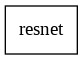

In [13]:
plot_model(resnet_model , to_file = "resnet.png" , show_shapes = True , show_layer_names = True)